# **Imports and Constants**

In [1]:
#imports
from __future__ import print_function
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from mpl_toolkits.mplot3d import Axes3D
from pyspark.sql.functions import col
from functools import reduce
from pyspark import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.sql.functions import col, split, size, isnan, array_contains, array_min, when, count
from pyspark.sql.types import StructType, StructField, TimestampType, StringType, FloatType
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import pandas as pd 
import glob
import re
import pathlib
import json
import datetime
import numpy as np
import time
import os
import random
import statistics

In [2]:
#paths
DATASET_PATH='/Users/Soroush/Desktop/Thesis/Code/dataset/'

#from google.colab import drive
#drive.mount('/gdrive')

# **Install spark**

In [ ]:
# Install spark and dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://mirror.its.dal.ca/apache/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz #or any other version
!tar xvf spark-2.4.5-bin-hadoop2.7.tgz #based on version
!pip install -q findspark

# Set up required environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7" #based on version

#imports
import findspark
findspark.init()
import pyspark # Call this only after findspark.init()
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

#test
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)
file_loc = './sample_data/california_housing_train.csv'
df = spark.read.csv(file_loc, inferSchema=True, header =True)
df.show()

# **Load/Save Dataset**

In [3]:
#load and save .read_pickle() and .to_pickle() 

#save

#dataset.to_pickle(DATASET_PATH+"dataset.pkl")
#aggregated_dataset.to_pickle(DATASET_PATH+"aggregated_dataset.pkl")
#json_dataset.to_pickle(DATASET_PATH+"json_dataset.pkl")
#dataset.to_csv(DATASET_PATH+"dataset.csv")
#aggregated_dataset.to_csv(DATASET_PATH+"aggregated_dataset.csv")
#json_dataset.to_csv(DATASET_PATH+"json_dataset.csv")
#aggregated_dataset_rowBased.to_csv(DATASET_PATH+"aggregated_dataset_rowBased.csv")


#load

dataset=pd.read_pickle(DATASET_PATH+"dataset.pkl")
aggregated_dataset=pd.read_pickle(DATASET_PATH+"aggregated_dataset.pkl")
json_dataset=pd.read_pickle(DATASET_PATH+"json_dataset.pkl")


# **Preprocessing (for Smart* Dataset)**

In [ ]:
#create appropriate dataset

# dataset address: http://traces.cs.umass.edu/index.php/Smart/Smart

#Extract File
#import tarfile
#!tar -xf '/gdrive/My Drive/a.gzip' -C '/gdrive/My Drive/'

#load

def load_smart_star_dataset(dataset_path): 
    
    #length of file path
    LENGTH=len(dataset_path)+5

    df_merged = pd.DataFrame(columns=['date'])
    
    # 2014
    #path_2014 = r'/gdrive/My Drive/Dataset/apartment/2014'
    path_2014= dataset_path+'2014'
    all_2014_paths = glob.glob(path_2014 + "/Apt*.csv")
    df_merged_2014 = pd.DataFrame(columns=['date'])
    for file_name in all_2014_paths:
        column_name = file_name[LENGTH:-9]
        # column_name = file_name.replace("dataset/2014/", "").replace("_2014.csv","")
        df = pd.read_csv(file_name, names=["date", column_name])
        df_merged_2014 = pd.merge(df_merged_2014, df, on='date', how='outer', left_index=True, right_index=True)
    
    # 2015
    df_merged_2015 = pd.DataFrame(columns=['date'])
    #path_2015 = r'/gdrive/My Drive/Dataset/apartment/2015'
    path_2015= dataset_path+'2015'
    all_2015_paths = glob.glob(path_2015 + "/Apt*.csv")
    for file_name in all_2015_paths:
        column_name = file_name[LENGTH:-9]
        # column_name = file_name.replace("dataset/2015/", "").replace("_2015.csv","")
        df = pd.read_csv(file_name, names=["date", column_name])
        df_merged_2015 = pd.merge(df_merged_2015, df, on='date', how='outer', left_index=True, right_index=True)
    
    # 2016
    df_merged_2016 = pd.DataFrame(columns=['date'])
    #path_2016 = r'/gdrive/My Drive/Dataset/apartment/2016'
    path_2016= dataset_path+'2016'
    all_2016_paths = glob.glob(path_2016 + "/Apt*.csv")
    for file_name in all_2016_paths:
        column_name = file_name[LENGTH:-9]
        # column_name = file_name.replace("dataset/2016/", "").replace("_2016.csv","")
        df = pd.read_csv(file_name, names=["date", column_name])
        df_merged_2016 = pd.merge(df_merged_2016, df, on='date', how='outer', left_index=True, right_index=True)
    
    # merge all years
    df_merged = df_merged_2014.append(df_merged_2015, ignore_index=True).append(df_merged_2016, ignore_index=True)
    final = df_merged
    #save
    return final

In [ ]:
#aggregate data

def agg_by_date(final):
    final['date'] = pd.to_datetime(final['date'],)
    final.index=final['date']

    final_agg_by_hour = final.resample('60T').sum(min_count=1)  #for more than to NaN : .apply(lambda x: x.sum() if x.isnull().sum() <= 2 else np.nan)

    final = final_agg_by_hour.resample('D').aggregate(lambda x: x.tolist()) # for tuple: .aggregate(lambda x: tuple(x))

    #remove first and last row
    #aggregated_dataset.drop(pd.to_datetime('2016-12-28'),inplace=True)
    #aggregated_dataset.drop(pd.to_datetime('2014-10-15'),inplace=True)
    #final=final.iloc[1:-1]

    return final

In [ ]:
#convert column_based df to row_based

def col_to_row(df):
    #house_id=df.columns
    df.reset_index(inplace=True)
    return pd.melt(df, id_vars=['date'],value_name='power')

#aggregated_dataset=pd.read_pickle(DATASET_PATH+"aggregated_dataset.pkl")
#aggregated_dataset_rowBased=col_to_row(aggregated_dataset)
#aggregated_dataset_rowBased.sort_values(['date', 'variable'], ascending=[True, True],inplace=True)

In [ ]:
#create dataset
dataset = load_smart_star_dataset(DATASET_PATH)

#aggregate by date
aggregated_dataset=agg_by_date(dataset)
aggregated_dataset=aggregated_dataset[1:-1]

#to json
json_dataset=to_json(aggregated_dataset)

# **Model**

In [4]:
#create SparkSession
spark = SparkSession.builder.appName("anomaly_detection").master("local[2]").getOrCreate()

#define schema
schema = StructType([
    StructField("#", IntegerType()),
    StructField("date", TimestampType()),
    StructField("id", StringType()),
    StructField("power", StringType())])

#read data
sdf = spark.read.format('csv').options(header='true',inferSchema=True ,schema=schema).load(DATASET_PATH+"aggregated_dataset_rowBased.csv")

#rename columns
def rename_dataframe(sdf):
    names = ['#','date','id','power']
    for c,n in zip(sdf.columns,names):
        sdf=sdf.withColumnRenamed(c,n)
    return sdf
    
sdf=rename_dataframe(sdf)
#sdf.show()
    
#convert power to array
def string_power_to_array(sdf):
    temp=sdf.withColumn("power", f.regexp_replace(f.regexp_replace(f.col("power"), "\\[", ""),"\\]","")
                        .alias("power"))
    temp=temp.withColumn("power",split(col("power"), ",\s*")
                        .cast(ArrayType(FloatType())).alias("power"))
    return temp

sdf=string_power_to_array(sdf)
#sdf.show()

#add validation column
def add_validation_column(sdf):
    v=True
    temp=sdf.withColumn("V",f.when((size(sdf.power)==24) #array size
                                   & ~(f.array_contains(sdf.power, float('nan'))) #containing NaN
                                   & ~(f.array_max(sdf.power)<=0) #all 0
                                   , True).otherwise(False))
    return temp

#sdf=add_validation_column(sdf)
#sdf.show()


def split_power(sdf):
    temp=sdf.select("#","date","id",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
    return temp
    
#split_sdf=split_power(sdf)
#split_sdf.show()
#split_sdf=add_validation_column(split_sdf)


In [5]:
def prepare_for_kmeans(sdf): 
    
    temp=sdf
    
    #define function for validation
    def add_validation_column(sdf):
        v=True
        temp=sdf.withColumn("V",f.when((size(sdf.power)==24) #array size
                                   & ~(f.array_contains(sdf.power, float('nan'))) #containing NaN
                                   & ~(f.array_max(sdf.power)<=0) #all 0
                                   , True).otherwise(False))
        return temp

    #call the split_power function
    temp=add_validation_column(temp)
    
    #define function for split power column
    def split_power(sdf):
        temp=sdf.select("#","V","date","id",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
        return temp
    
    #call the split_power function
    temp=split_power(temp)
    
    #filter date
    temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") 
    
    #filter valid rows
    temp=temp.filter(temp.V==True)
    
    FEATURES = ['H0', 'H1', 'H2','H3', 'H4', 'H5','H6', 'H7', 'H8','H9', 'H10', 'H11',
            'H12', 'H13', 'H14','H15', 'H16', 'H17','H18', 'H19', 'H20','H21', 'H22', 'H23']
    
    #make ready
    vecAssembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    df_kmeans = vecAssembler.transform(temp).select('id', 'features')
    return df_kmeans



+------+--------------------+
|    id|            features|
+------+--------------------+
| Apt36|[1.96932005882263...|
| Apt36|[0.61410224437713...|
| Apt36|[1.37804222106933...|
| Apt36|[1.16347885131835...|
| Apt37|[2.35953211784362...|
| Apt37|[4.40217113494873...|
| Apt37|[2.70866441726684...|
| Apt37|[4.42925310134887...|
| Apt40|[1.71935439109802...|
| Apt40|[5.16754436492919...|
| Apt40|[10.3177185058593...|
| Apt40|[5.52604532241821...|
|Apt105|[3.02236342430114...|
|Apt105|[3.41390442848205...|
|Apt105|[2.79135322570800...|
|Apt105|[2.98783564567565...|
| Apt75|(24,[18],[0.00162...|
| Apt75|(24,[10],[0.00162...|
| Apt74|[4.72036647796630...|
| Apt91|[1.07712554931640...|
+------+--------------------+
only showing top 20 rows

133
root
 |-- id: string (nullable = true)
 |-- features: vector (nullable = true)

Silhouette with squared euclidean distance = 0.33884694671053045
Cluster Centers: 
[ 7.56248801 11.34643051  9.02241417  7.9526375   7.4155505   6.76336997
  5.90136327  

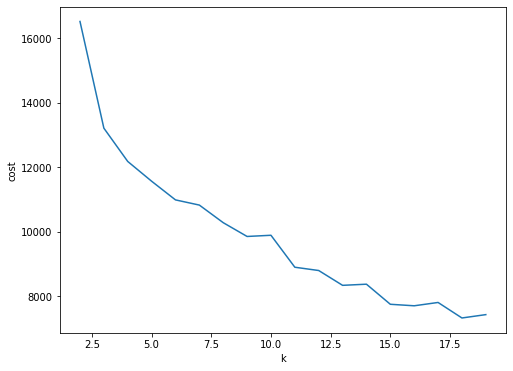

In [6]:
#run k-means

# Loads data
sdf_kmeans=prepare_for_kmeans(sdf)

#show data
sdf_kmeans.show()
print(sdf_kmeans.count())
sdf_kmeans.printSchema()

#find best k
MAX_k=20
cost = np.zeros(MAX_k)
for k in range(2,MAX_k):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(sdf_kmeans)
    cost[k] = model.computeCost(sdf_kmeans) # requires Spark 2.0 or later
    
#show best k
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,MAX_k),cost[2:MAX_k])
ax.set_xlabel('k')
ax.set_ylabel('cost')

# Trains a k-means model.
kmeans = KMeans().setK(6).setSeed(1)
model = kmeans.fit(sdf_kmeans)

# Make predictions
predictions = model.transform(sdf_kmeans)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

transformed = model.transform(sdf_kmeans).select('id', 'prediction')
rows = transformed.collect() 
print(rows[:3])
#prediction = spark.createDataFrame(rows)
#prediction.show()

# **Malicious Samples**

In [75]:
# Generate malicious samples
def h1(x):
    MAX=0.8
    MIN=0.1
    alpha=random.uniform(MIN,MAX)
    temp=np.array(x)
    return (temp*alpha).tolist()

def h2(x):
    MIN_OFF=4 # hour
    DURATION=random.randint(MIN_OFF,24)
    START=random.randint(0,23-DURATION) if DURATION!=23 else 0
    END=START+DURATION
    temp=np.array(x)
    temp[START:END]=0
    return temp.tolist()
    
def h3(x):
    MAX=0.8
    MIN=0.1
    temp=[]
    for i in range(len(x)):
        temp.append(x[i]*random.uniform(MIN,MAX))
    return temp

def h4(x):
    MAX=0.8
    MIN=0.1
    mean=statistics.mean(x)
    temp=[]
    for i in range(len(x)):
        temp.append(mean*random.uniform(MIN,MAX))
    return temp

def h5(x):
    MAX=0.8
    MIN=0.1
    mean=statistics.mean(x)
    temp=[]
    for i in range(len(x)):
        temp.append(mean)
    return temp

def h6(x):
    temp=np.array(x)
    #temp=temp[::-1] 
    temp=np.flipud(temp) 
    return temp

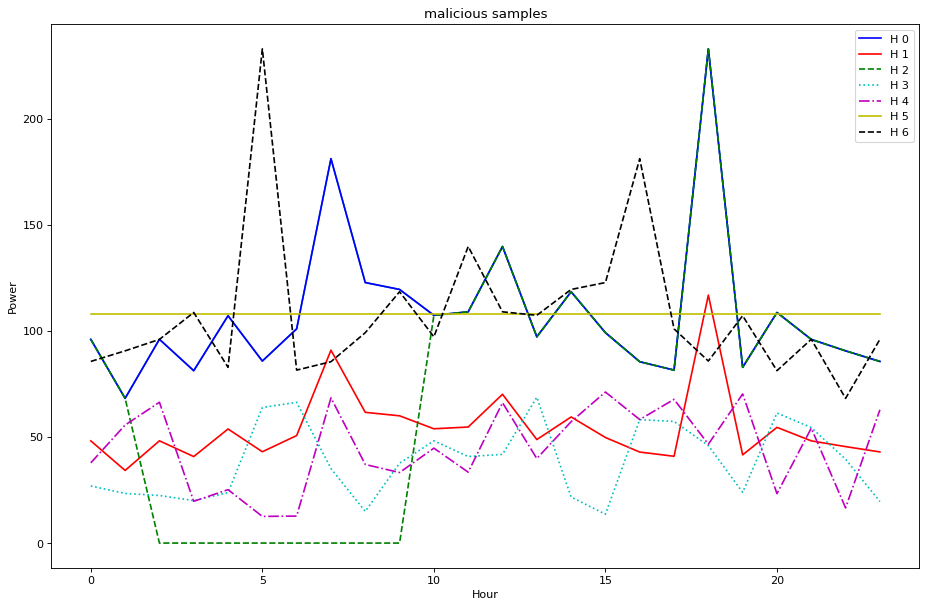

In [76]:
#plot
read_value=[96.00396728515625, 68.20671844482422, 96.05184936523438, 81.24053192138672, 107.14600372314453, 85.7899169921875, 100.9619140625, 181.16192626953125, 122.7833023071289, 119.53163146972656, 107.34815216064453, 108.99268341064453, 139.76922607421875, 97.21031951904297, 118.4515151977539, 99.15070343017578, 85.47505187988281, 81.51718139648438, 232.91493225097656, 82.83419799804688, 108.6827163696289, 95.99102020263672, 90.59868621826172, 85.60449981689453]
lists=[]
colors=['b','r-','g--','c:','m-.','y-','k--']
lists.append(read_value)
lists.append(h1(read_value))
lists.append(h2(read_value))
lists.append(h3(read_value))
lists.append(h4(read_value))
lists.append(h5(read_value))
lists.append(h6(read_value))
plt.figure(num=None, figsize=(14, 9), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel("Hour")
plt.ylabel("Power")
plt.title("malicious samples")
plt.plot(read_value)
for i in range(len(lists)):
    plt.plot(lists[i],colors[i],label = 'H %s'%i)
plt.legend()
plt.show()

# **MAIN**

# **TEST**

In [ ]:
rows = transformed.collect() 
spark.createDataFrame(rows, IntegerType()).show()
#print(rows[:3])
#p = spark.createDataFrame(rows)
#p.show()
#df_pred = df_pred.join(df, 'id')
#df_pred.show()

# **Other**

In [ ]:
#create json data from stored dataframe

def to_json(final):
    PERIOD=60

    data_for_json=final.loc[:, final.columns != 'date']

    def date_to_str(o):
        if isinstance(o, datetime.datetime):
            return o.__str__()

    json_dataframe = pd.DataFrame(columns=['data']) #creates a new dataframe that's empty
    L  = []

    import json
    import datetime
    import time

    r, c = data_for_json.shape
    for i in range(0, r):
        for j in range(0, c):
            data = {}
            data['id'] = data_for_json.columns.values[j]
            data['power'] = data_for_json.iloc[i][j]
            data['date']=data_for_json.index.tolist()[i]
            json_data = json.dumps(data,default=date_to_str)
            L.append(json_data)
            #json_dataframe=json_dataframe.append(json_data,ignore_index=True)

    json_dataframe = pd.DataFrame(L, columns=['data'])
    return json_dataframe

In [ ]:
#load by schema

schema = StructType([
  StructField("num", IntegerType()),
    StructField("date", TimestampType()),
    StructField("id", StringType()),
  StructField("power", ArrayType(
      StructType([
          StructField("H0", FloatType(), True),
          StructField("H1", FloatType(), True),
          StructField("H2", FloatType(), True),
          StructField("H3", FloatType(), True),
          StructField("H4", FloatType(), True),
          StructField("H5", FloatType(), True),
          StructField("H6", FloatType(), True),
          StructField("H7", FloatType(), True),
          StructField("H8", FloatType(), True),
          StructField("H9", FloatType(), True),
          StructField("H10", FloatType(), True),
          StructField("H11", FloatType(), True),
          StructField("H12", FloatType(), True),
          StructField("H13", FloatType(), True),
          StructField("H14", FloatType(), True),
          StructField("H15", FloatType(), True),
          StructField("H16", FloatType(), True),
          StructField("H17", FloatType(), True),
          StructField("H18", FloatType(), True),
          StructField("H19", FloatType(), True),
          StructField("H20", FloatType(), True),
          StructField("H21", FloatType(), True),
          StructField("H22", FloatType(), True),
          StructField("H23", FloatType(), True)
      ])
   )
             )])

a = spark.read.format('csv').schema(schema).option("header", "true").load(DATASET_PATH+"f.csv")
a.show()